In [1]:
from os.path import join
import json
import csv

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from IPython.display import Image
import numpy as np

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [5]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')
prf = prf.join(abundances, ['sample type', 'sample'])

In [6]:
prf = prf[(prf['sample type'] != 'single-strain') &
          (prf['sample type'] != 'sterile-water-blank') &
          (prf['sample type'] != 'mock-community') &
          (prf['sample type'] != 'plant-surface')]
prf = prf[(prf['class weights'] == 'bespoke70') |
          (prf['class weights'] == 'uniform70')]
prf = prf[prf['method'] == 'weighted']
level7 = prf[((prf['level'] == 7) & (prf['class weights'] == 'bespoke70')) |
             ((prf['level'] == 6) & (prf['class weights'] == 'uniform70'))]

In [7]:
bespoke = level7[level7['class weights'] == 'bespoke70']
bespoke.rename(columns={'F-measure':'bespoke'}, inplace=True)
uniform = level7[level7['class weights'] == 'uniform70']
uniform.rename(columns={'F-measure':'uniform'}, inplace=True)
uniform = uniform.set_index(['sample type', 'sample'])
for_diff = bespoke.join(uniform, ['sample type', 'sample'], rsuffix='_uniform')

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [8]:
grouped = for_diff.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    d1 = DescrStatsW(x['bespoke'] - x['uniform'], weights=x['abundance'])
    lower, upper = d1.tconfint_mean()
    return Series([d1.mean, lower, upper], index=['mean', 'lower', 'upper'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [9]:
old_labels = 'uniform70', 'bespoke70'
new_labels = 'Uniform Genus Level', 'Bespoke Species Level'
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'plant-surface',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['sample type'] == old, 'sample type'] = new
figure1['direction'] = ['none']*len(figure1)
figure1.loc[figure1['mean'] >= 0., 'direction'] = 'Bespoke Species Level'
figure1.loc[figure1['mean'] < 0., 'direction'] = 'Uniform Genus Level'

In [10]:
%%R -i figure1
figure1$sample.type = factor(figure1$sample.type, levels=c(
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'))
figure1$class.weights = factor(figure1$class.weights, levels=c(
    'Uniform Genus Level', 'Bespoke Species Level'
))
cbPalette <- c("#009E73", "#E69F00")
ggplot(data=figure1, aes(x=sample.type, y=mean, fill=direction)) +
  geom_bar(stat="identity", position="identity") +
  coord_flip() + 
  theme_bw() +
  theme(legend.position="bottom", 
        legend.direction="horizontal") +
  labs(x='EMPO3 Habitat', y='Unfair F-measure Difference') +
  geom_errorbar(aes(ymin=lower, ymax=upper), position=position_dodge()) +
  scale_fill_manual(values=cbPalette) +
  guides(fill=guide_legend(title="More Accurate", nrow=2, byrow=TRUE))
ggsave(file="figure3.png", width=5, height=5, dpi=300)

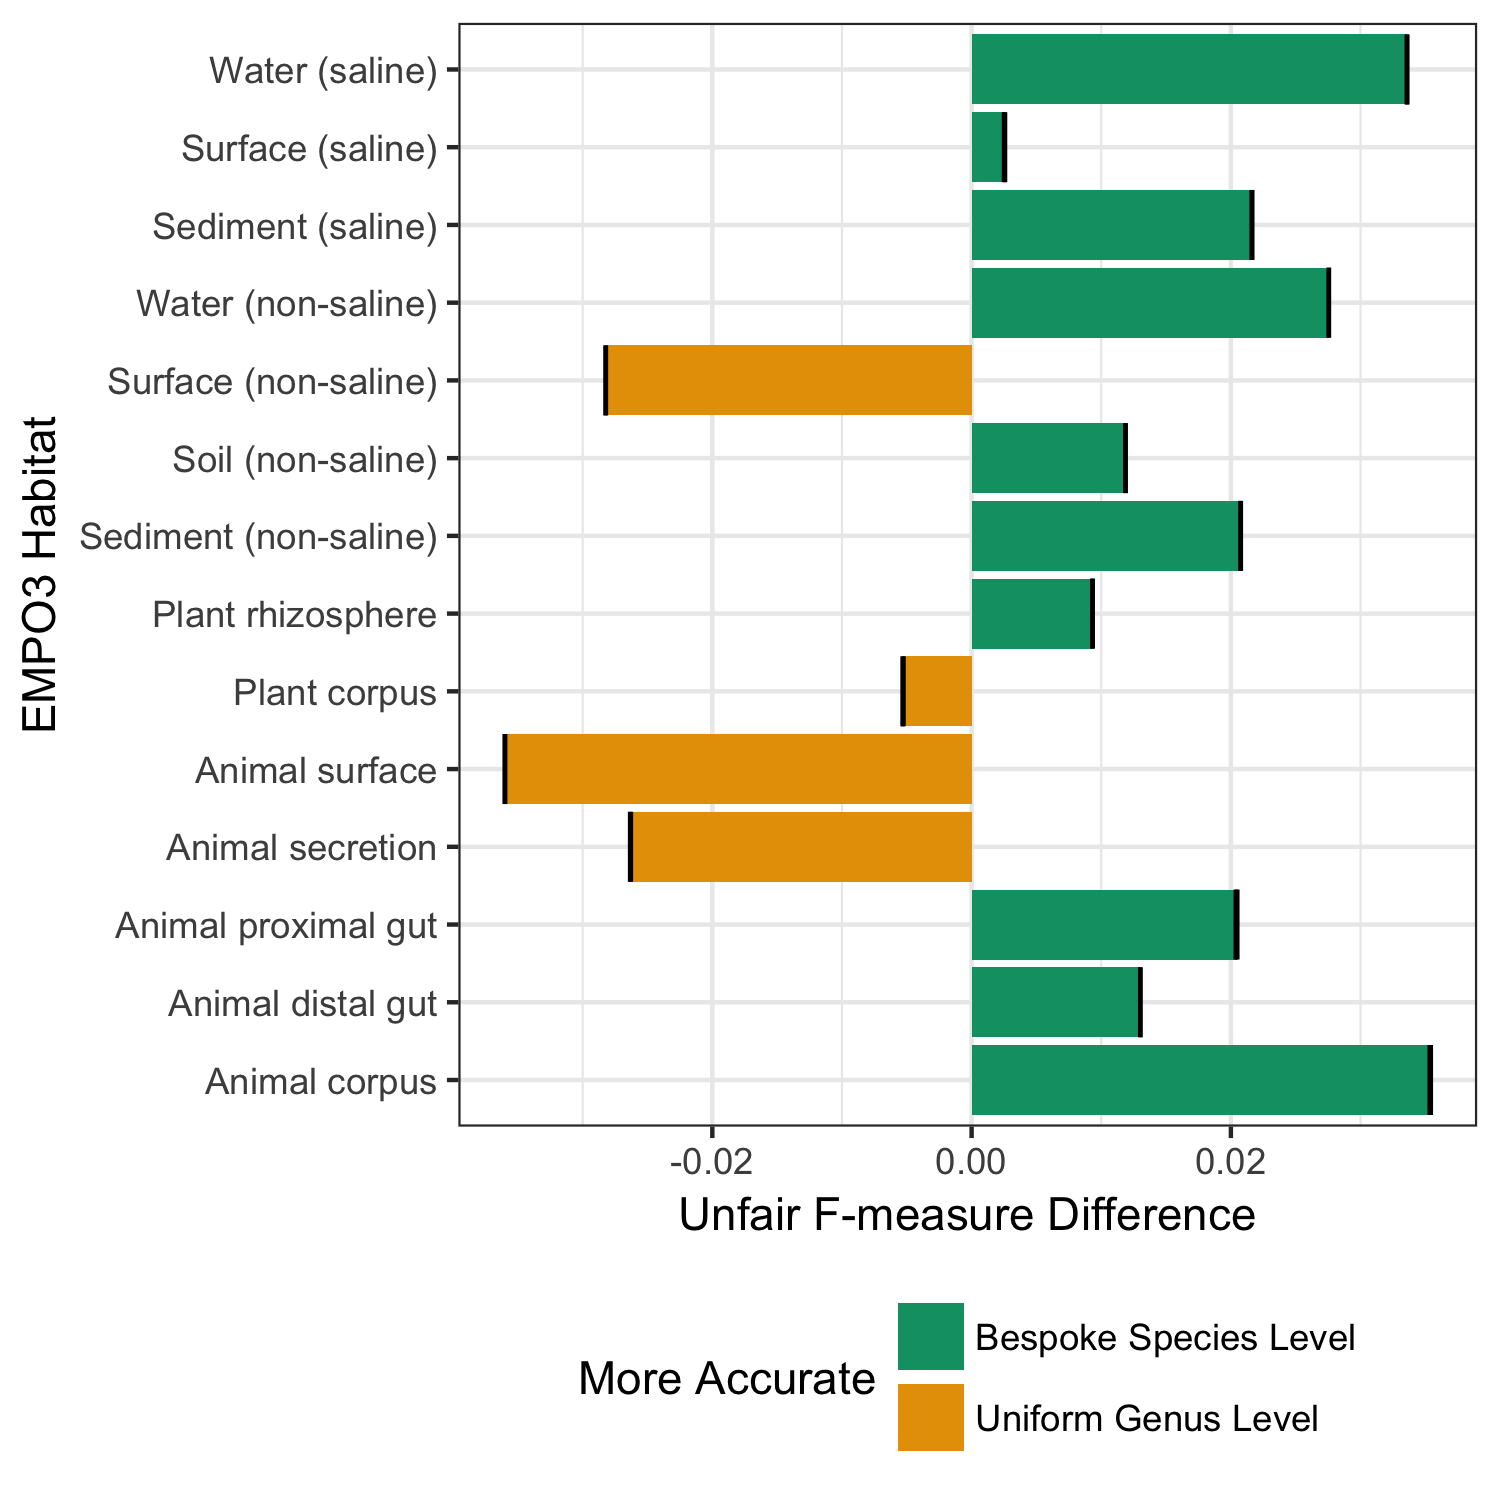

In [11]:
Image("figure3.png")

In [9]:
figure1['diff'] = [0.]*len(figure1)
figure1.loc[figure1['class weights'] == 'Bespoke Species Level', 'diff'] = \
    np.array(figure1[figure1['class weights'] == 'Bespoke Species Level']['mean']) - \
    np.array(figure1[figure1['class weights'] == 'Uniform Genus Level']['mean'])
figure1.loc[figure1['class weights'] == 'Uniform Genus Level', 'diff'] = \
    - np.array(figure1[figure1['class weights'] == 'Bespoke Species Level']['diff'])
figure1.loc[figure1['diff'] < 0., 'diff'] = 0
figure1.loc[figure1['class weights'] == 'Uniform Genus Level', 'diff'] = \
    - figure1.loc[figure1['class weights'] == 'Uniform Genus Level', 'diff']

In [12]:
max(figure1['upper'] - figure1['lower'])

0.00014978026206025064

In [44]:
bespoke = level7[level7['class weights'] == 'bespoke70']
bespoke.rename(columns={'F-measure':'bespoke'}, inplace=True)
uniform = level7[level7['class weights'] == 'uniform70']
uniform.rename(columns={'F-measure':'uniform'}, inplace=True)
uniform = uniform.set_index(['sample type', 'sample'])
for_diff = bespoke.join(uniform, ['sample type', 'sample'], rsuffix='_uniform')

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [45]:
bespoke

,Unnamed: 0,bespoke,Precision,Recall,Unnamed: 0.1,class weights,fold,level,method,sample,sample type,abundance
32430,32430,0.718409,0.723803,0.713095,6.0,bespoke70,1,7,weighted,10798.AC.B.4C.2016.42723,animal-corpus,12234
32444,32444,0.860550,0.888510,0.834297,6.0,bespoke70,1,7,weighted,10798.MC.B.1D.2016.42723,animal-corpus,27157
32458,32458,0.933123,0.970978,0.898109,6.0,bespoke70,1,7,weighted,1064.G.CV239.27125,animal-corpus,13858
32472,32472,0.821406,0.861924,0.784526,6.0,bespoke70,1,7,weighted,10798.AST.2D.42736,animal-corpus,21404
32486,32486,0.787179,0.910214,0.693445,6.0,bespoke70,1,7,weighted,10273.BIOS.SW.Cont7T8.30649,animal-corpus,36124
32500,32500,0.797585,0.836550,0.762088,6.0,bespoke70,1,7,weighted,1064.G.CV95.27125,animal-corpus,10920
32514,32514,0.880952,0.895161,0.867188,6.0,bespoke70,1,7,weighted,10798.AC.C.2A.2016.42736,animal-corpus,256
32528,32528,0.951930,0.977747,0.927441,6.0,bespoke70,1,7,weighted,10798.AC.C.3D.2016.42736,animal-corpus,758
32542,32542,0.845242,0.874089,0.818238,6.0,bespoke70,1,7,weighted,10798.MC.C.6C.2016.42736,animal-corpus,1612
32556,32556,0.941295,0.950393,0.932370,6.0,bespoke70,1,7,weighted,10798.PM.B.5D.42723,animal-corpus,33432


In [46]:
uniform

Unnamed: 0  \
sample type   sample                                                           
animal-corpus 10798.AC.B.4C.2016.42723                                 48641   
              10798.MC.B.1D.2016.42723                                 48655   
              1064.G.CV239.27125                                       48669   
              10798.AST.2D.42736                                       48683   
              10273.BIOS.SW.Cont7T8.30649                              48697   
              1064.G.CV95.27125                                        48711   
              10798.AC.C.2A.2016.42736                                 48725   
              10798.AC.C.3D.2016.42736                                 48739   
              10798.MC.C.6C.2016.42736                                 48753   
              10798.PM.B.5D.42723                                      48767   
              10798.ASTREO.C.1F.42736                                  48781   
              1064.H.CJV197.27125                                      48795   
              10798.AC.C.6E.2015.42736                                 48809   
              10798.PM.B.3A.2016.42736                                 48823   
              10798.PM.B.2D.2016.42736                                 48837   
              1064.W.CJV223.27125                                      48851   
              910.CuracaoCCA5B.30367                                   48865   
              1064.G.CV243.27125                                       48879   
              1799.11.N.SD7.27421                                      48893   
              1064.G.CV26.27125                                        48907   
              1064.W.CV356.27125                                       48921   
              10798.MM.C.5D.42723                                      48935   
              1064.G.CV305.27125                                       48949   
              10798.ASTREO.C.8D.42723                                  48963   
              10798.MC.B.6A.42723                                      48977   
              10798.AA.B.4C.42723                                      48991   
              910.AcrC6.30367                                          49005   
              10798.ASTREO.C.4F.2015.42736                             49019   
              10798.MA.B.2D.42723                                      49033   
              1064.H.CV329.27125                                       49047   
...                                                                      ...   
water-saline  10308.J5.3.F.30930                                     1233825   
              1240.0911BCDNA.30131                                   1233839   
              1240.0109T.30131                                       1233853   
              723.IC4.S2.L3.Catlin2.16Spool.110602.HWI.EAS137...     1233867   
              10308.P6.MARSH3.F.30930                                1233881   
              1240.0401B.30131                                       1233895   
              2080.S79D5.28562                                       1233909   
              1240.0911T.30131                                       1233923   
              662.M33.30223                                          1233937   
              1240.0707TCDNA.30131                                   1233951   
              1240.2206TCDNA.30131                                   1233965   
              1240.1101B.30131                                       1233979   
              1222.B1.5.8.06.30237                                   1233993   
              10308.P3B.F.30930                                      1234007   
              1240.1409T.30131                                       1234021   
              1240.0102B.30131                                       1234035   
              1240.1801BCDNA.30131                                   1234049   
              10934.AB.r.water.i2.36561                           

In [48]:
for_diff

,Unnamed: 0,bespoke,Precision,Recall,Unnamed: 0.1,class weights,fold,level,method,sample,...,Unnamed: 0_uniform,uniform,Precision_uniform,Recall_uniform,Unnamed: 0.1_uniform,class weights_uniform,fold_uniform,level_uniform,method_uniform,abundance_uniform
32430,32430,0.718409,0.723803,0.713095,6.0,bespoke70,1,7,weighted,10798.AC.B.4C.2016.42723,...,48641,0.677042,0.966778,0.520925,5.0,uniform70,1,6,weighted,12234
32444,32444,0.860550,0.888510,0.834297,6.0,bespoke70,1,7,weighted,10798.MC.B.1D.2016.42723,...,48655,0.874715,0.912983,0.839526,5.0,uniform70,1,6,weighted,27157
32458,32458,0.933123,0.970978,0.898109,6.0,bespoke70,1,7,weighted,1064.G.CV239.27125,...,48669,0.837706,0.862383,0.814403,5.0,uniform70,1,6,weighted,13858
32472,32472,0.821406,0.861924,0.784526,6.0,bespoke70,1,7,weighted,10798.AST.2D.42736,...,48683,0.734522,0.793878,0.683424,5.0,uniform70,1,6,weighted,21404
32486,32486,0.787179,0.910214,0.693445,6.0,bespoke70,1,7,weighted,10273.BIOS.SW.Cont7T8.30649,...,48697,0.741758,0.872720,0.644973,5.0,uniform70,1,6,weighted,36124
32500,32500,0.797585,0.836550,0.762088,6.0,bespoke70,1,7,weighted,1064.G.CV95.27125,...,48711,0.636229,0.718185,0.571062,5.0,uniform70,1,6,weighted,10920
32514,32514,0.880952,0.895161,0.867188,6.0,bespoke70,1,7,weighted,10798.AC.C.2A.2016.42736,...,48725,0.498584,0.907216,0.343750,5.0,uniform70,1,6,weighted,256
32528,32528,0.951930,0.977747,0.927441,6.0,bespoke70,1,7,weighted,10798.AC.C.3D.2016.42736,...,48739,0.889831,0.957447,0.831135,5.0,uniform70,1,6,weighted,758
32542,32542,0.845242,0.874089,0.818238,6.0,bespoke70,1,7,weighted,10798.MC.C.6C.2016.42736,...,48753,0.843279,0.894298,0.797767,5.0,uniform70,1,6,weighted,1612
32556,32556,0.941295,0.950393,0.932370,6.0,bespoke70,1,7,weighted,10798.PM.B.5D.42723,...,48767,0.904026,0.933784,0.876107,5.0,uniform70,1,6,weighted,33432


In [31]:
bespoke[bespoke['sample'] == '10798.AC.B.4C.2016.42723']

,Unnamed: 0,bespoke,Precision,Recall,Unnamed: 0.1,class weights,fold,level,method,sample,sample type,abundance
32430,32430,0.718409,0.723803,0.713095,6.0,bespoke70,1,7,weighted,10798.AC.B.4C.2016.42723,animal-corpus,12234


KeyError: 'wtf'